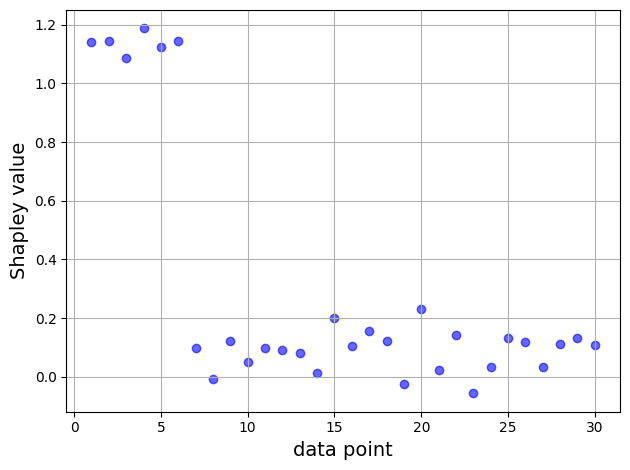

[ 1.1418482   1.14412655  1.08591178  1.18809328  1.1226583   1.14304164
  0.09685679 -0.00801707  0.12042918  0.04881875  0.0987685   0.09082127
  0.08057427  0.01235813  0.19962231  0.10495683  0.15450121  0.12116885
 -0.0231513   0.23109995  0.02237568  0.14398619 -0.05673132  0.03437149
  0.13169937  0.11734107  0.03502257  0.1132199   0.13238876  0.10970124]
耗时： 1412.324033498764 s


In [3]:
import numpy as np
import time
import math
import sympy as sp
import random
from itertools import permutations
from multiprocessing import Pool, freeze_support
from scipy.stats import invgamma
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


dataset = np.array([10.01769447, 10.06923099, 10.06665355,  9.98286628,  9.92245355, 10.01378089,
                   11.58835573 ,11.66084466 ,11.60612279, 11.65167558, 11.59958176 ,11.60105934,
 11.6644912 , 11.64641932 ,11.62979292, 11.66409849,11.64323261, 11.61256012,
 11.5894299 , 11.58006899, 11.65612268, 11.5998781 , 11.69453838 ,11.64668659,
 11.61357351, 11.60527658 ,11.66324746, 11.60354948 ,11.63437253, 11.64986473])

n_size = 30
T = 4

num_e = T - 2
num_s = 3
num_a = 1


m_fix = np.ones(T)
m_fix = m_fix / 1
b = np.ones((T, num_a))
b = b / 1
c = np.ones((T, num_s))
c = c / 1

matrix_p = 0.1*np.ones((T, num_a, num_s))

mu_s = np.random.normal(1, 0, size=(T, num_s))
mu_a = np.random.normal(1, 0, size=(T, num_a))


mu_0 = 10
std_0 = 2 # 先验
std = 2 # 总体

def policy(st,mu_a_t,mu_s_t,matrix_p_t):
    at = mu_a_t+ np.dot(matrix_p_t, st-mu_s_t)
    return at

def reward(mt,bt,ct,at,st):
    rt = mt + np.dot(bt,at)+ np.dot(ct,st)
    return rt

def f(st,at,mu_s_t1,mu_s_t,mu_a_t,beta_s_t, beta_a_t):
    s_t1 = mu_s_t1 + 1*np.dot(beta_s_t, st-mu_s_t) + 1*np.dot(beta_a_t, at-mu_a_t)
    return s_t1

def P(perm, i):
    m_index = perm.index(i)
    if m_index > 0:
        ele_list = list(perm[0:m_index])
        return ele_list
    else:
        return list()

def simulate_begin(e,sample_beta):
    beta_s[2][0] = np.ones(( num_s))*sample_beta*0.2
    beta_a[2][0] = np.ones((num_a))*sample_beta*0.2
    for t in range(1, T):
        a[t] = policy(s[t], mu_a[t], mu_s[t], matrix_p[t])
        if t + 1 < T:
            s[t + 1] = f(s[t], a[t], mu_s[t + 1], mu_s[t], mu_a[t], beta_s[t], beta_a[t]) + e[t-1]
        r[t] = reward(m_fix[t], b[t], c[t], a[t], s[t])
        R[t] = R[t - 1] + r[t]
    return R[T - 1]


def g_hat(subset):
    if len(subset) == 0:
        return 0
    else:
        sample_size = 1000
        mu = 10 
        pos_value = np.zeros(sample_size)
        alpha_n, beta_n = update_pdf(subset) 
        sigma2 = beta_n/(alpha_n-1)

        for i in range(sample_size):
            e = np.random.normal(loc = 0 , scale = 0.1,size = 2)
            posterior = np.random.normal(loc = mu, scale = np.sqrt(sigma2))
            pos_value[i] = simulate_begin(e,posterior)
        res = 26.24 - np.var(pos_value, ddof =1)
    return res

def generate_random_order(num):
    numbers = list(range(num))
    random.shuffle(numbers)
    return numbers


def update_pdf(subset): 
    alpha_0 = 3 # 形状参数
    beta_0 = 8 # 尺度参数
    mu = 10 # 设置总体均值
    alpha_n = alpha_0 + len(subset)/2 # 更新形状参数
    beta_n = beta_0 + 0.5*np.sum([(i-mu)**2 for i in dataset[subset]])
    return alpha_n, beta_n

pm= 500
s_time = time.time()
# 初始化
R = np.zeros(T)
r = np.zeros(T)
s = np.zeros((T, num_s))
a = np.zeros((T, num_a))
s[1] = 2*np.ones(num_s)
beta_s = np.ones((T, num_s, num_s))
beta_a = np.ones((T, num_s, num_a))
Sh = np.zeros(n_size)
for _ in range(pm):
    perm = generate_random_order(n_size)
    for i in range(n_size):
        Sh[i] = Sh[i] + g_hat(P(perm,i)+[i]) - g_hat(P(perm,i))
Sh = Sh/pm

    
x_values = list(range(1,n_size+1))
y_values = Sh
plt.scatter(x_values, y_values, color='blue', alpha=0.6)

# 设置标题和标签
#plt.title('Scatter Plot of Random Data')
plt.xlabel('data point',fontsize=14)
plt.ylabel('Shapley value',fontsize=14)


# 显示图形
plt.grid()
plt.tight_layout()
#plt.savefig('true_Sh.png', bbox_inches='tight', dpi=300)
plt.show()
e_time = time.time()
print(Sh)
print('耗时：',e_time - s_time,'s')

In [7]:
print(np.mean(Sh[6:]))

0.08800761007420206
